In [1]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import namedtuple, deque
from IPython import display
# pip install git+https://github.com/jakevdp/JSAnimation.git
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
%load_ext autoreload
%autoreload
run = 0

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Actions: 2
Raw observation space: (4,)
Max episode steps: 200
((4,), 1.0)
count    4.000000
mean     0.026707
std      0.174219
min     -0.146667
25%     -0.050359
50%     -0.007467
75%      0.069599
max      0.268429
dtype: float64


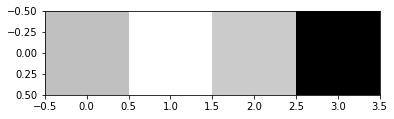

In [2]:
class PongV0Wrapper(gym.ObservationWrapper):
    def preprocess_input_pong_v0(self, I):
        I = I[35:195]
        I[I == 144] = 0
        I[I == 109] = 0
        I = I[::2,::2,0] + I[1::2,::2,0] + I[::2,1::2,0] + I[1::2,1::2,0]
        I = I[::2,::2] + I[1::2,::2] + I[::2,1::2] + I[1::2,1::2]
        I = I[::2,::2] + I[1::2,::2] + I[::2,1::2] + I[1::2,1::2]
        I[I != 0] = 1
        I = I[0:19, 2:18]
        return I.astype(np.float)
        
    def observation(self, observation):
        return self.preprocess_input_pong_v0(observation)

# env = PongV0Wrapper(gym.make('Pong-v0'))
env = gym.make('CartPole-v0')
    
print('Actions: {}'.format(env.action_space.n))
print('Raw observation space: {}'.format(env.observation_space.shape))
print('Max episode steps: {}'.format(env.spec.max_episode_steps))

def test(env):
    state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    print(state.shape, reward)
    print(pd.Series(state.flatten()).describe())
    plt.imshow(state.reshape((1, 4)), cmap='Greys')

test(env)

In [32]:
class LearningParameters:
    def __init__(self, env, state, episodes_count):
        self.state_shape = state.shape
        self.state_size = np.prod(self.state_shape)
        self.action_size = env.action_space.n
        self.episodes_count = episodes_count
        self.max_frame_in_episode = env.spec.max_episode_steps
        self.max_memory_size = 100000
        self.episodes_between_think = 1
        self.episodes_warmup = 5

        self.gamma = 0.95                # rewards discount rate
        self.epsilon = 1.0               # exploration rate
        self.epsilon_start = self.epsilon
        self.epsilon_min = 0.0001        # min exploration rate
        self.learning_rate = 0.1         # learning rate for algorithm
        self.learning_rate_model = 0.01  # learning rate for model
        self.batch_size = 32
        
        self.reward_is_time = False
        self.discount_rewards = True
        self.normalize_rewards = True

def decay_exploration_rate(params, episode):
    # Exponential rate decay
    # y(0) = start
    # y(1) = start * x
    # y(2) = start * x^2
    # y(steps) = start * x^steps = min => x = (min/start) ^ (1/steps)
    # y(t) = start * x^t
    x = math.pow(params.epsilon_min / params.epsilon_start, 1.0 / params.episodes_count)
    params.epsilon = params.epsilon_start * math.pow(x, episode)

def set_rewards_time(episode_rewards):
    for i in range(len(episode_rewards)):
        episode_rewards[i] = len(episode_rewards) - i

def set_discount_rewards(episode_rewards):
    discounted_reward = 0.0
    for i in reversed(range(len(episode_rewards))):
        reward = episode_rewards[i]
        if params.pong_reset_discounted_reward and reward != 0:
            discounted_reward = 0.0
        discounted_reward = reward + discounted_reward * params.gamma
        episode_rewards[i] = discounted_reward
        
def normalize(arr):
    arr -= np.mean(arr)
    std = np.std(arr)
    if std != 0:
        arr /= std
    return arr
        
def train(session, tfwriter, env, agent, params):
    rewards = []

    for episode in range(params.episodes_count):
        state = env.reset()

        replays = []

        for frame in range(params.max_frame_in_episode):
            action = agent.act(session, state, frame)

            next_state, reward, done, _ = env.step(action)

            if done:
                break

            replays.append((frame, state, action, reward, next_state))
            state = next_state

        episode_rewards = list(r[3] for r in replays)
        rewards.append(sum(episode_rewards))
        
        if params.reward_is_time:
            set_rewards_time(episode_rewards)
        if params.discount_rewards:
            set_discount_rewards(episode_rewards)
        if params.normalize_rewards:
            episode_rewards = normalize(episode_rewards)

        for i in range(len(replays)):
            frame, state, action, _, next_state = replays[i]
            agent.remember(state, action, episode_rewards[i], next_state, frame)

        tfwriter.add_summary(tf.Summary(value=[
                tf.Summary.Value(tag='Summaries/Episode_reward', simple_value=rewards[-1]),
                tf.Summary.Value(tag='Summaries/Episode_frames', simple_value=len(replays)),
                tf.Summary.Value(tag='Summaries/Epsilon', simple_value=params.epsilon),
            ]), episode)

        if episode > params.episodes_warmup and (episode + 1) % params.episodes_between_think == 0:
            agent.think(session, tfwriter, params.batch_size, episode)

        decay_exploration_rate(params, episode)

    return agent, rewards

# https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
from IPython.display import clear_output, Image, display, HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [37]:
# Input: state, action OHE
# Output: next state, Q reward on state
# Train: (state, action, time delta) ~ (next state after time delta passed, reward)
class DqnAgentPredictDistantFuture:
    def __init__(self, params):
        self.params = params
        self.memory_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_next_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_actions = np.zeros((2 * self.params.max_memory_size), dtype=np.int32)
        self.memory_rewards = np.zeros((2 * self.params.max_memory_size))
        self.cnt = 0
        self._build_model()

    def _build_model(self):
        self.x = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_x")
        self.xnext = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_xnext")
        self.a = tf.placeholder("float", [None, self.params.action_size], name="Placeholder_a")
        self.y = tf.placeholder("float", [None], name="Placeholder_y")
        
        print('actions_ohe:', self.a)

        inp = tf.concat([self.x, self.a], axis=1)
        print('inp', inp)
        
        inner = tf.contrib.layers.fully_connected(
            inp,
            12,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('inner', inner)
        
        self.prednext = tf.contrib.layers.fully_connected(
            inputs=inner,
            num_outputs=self.params.state_size,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('self.prednext', self.prednext)
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=inner,
            num_outputs=1,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('self.pred', self.pred)
        
        cost_y = tf.reduce_mean(tf.squared_difference(self.pred, self.y))
        cost_state = tf.reduce_mean(tf.squared_difference(self.prednext, self.xnext))
        
        self.cost = cost_y + cost_state
        print('self.cost', self.cost)

        self.train_op = tf.train.GradientDescentOptimizer(learning_rate=self.params.learning_rate) \
            .minimize(self.cost)
            
        tf.summary.scalar('Summaries/Cost_QValue', cost_y)
        tf.summary.scalar('Summaries/Cost_Predict_State', cost_state)
        tf.summary.scalar('Summaries/Total_cost', self.cost)
        self.merged_summaries = tf.summary.merge_all()

    def remember(self, state, action, reward, next_state, frame):
        self.memory_states[self.cnt] = state
        self.memory_next_states[self.cnt] = next_state
        self.memory_actions[self.cnt] = action
        self.memory_rewards[self.cnt] = reward
        self.cnt += 1
        
        if self.cnt == 2 * self.params.max_memory_size:
            n = self.params.max_memory_size
            self.memory_states[:n] = self.memory_states[-n:]
            self.memory_next_states[:n] = self.memory_next_states[-n:]
            self.memory_actions[:n] = self.memory_actions[-n:]
            self.memory_rewards[:n] = self.memory_rewards[-n:]
            self.cnt = n

    def act(self, session, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(session, state, frame)
    
    def act_greedy(self, session, state, frame):
        act_values = session.run(self.pred, {
            self.x: [state] * 6,
            self.a: [
                [1., 0.],
                [0., 1.],
                [2., 0.],
                [0., 2.],
                [2., 1.],
                [1., 2.],
            ]})
        return np.argmax(act_values) % 2
    
    def think(self, session, tfwriter, batch_size, episode):
        cnt = self.cnt
        
        action0 = np.zeros((cnt, 2))
        action0[:,0] = 1.
        action1 = np.zeros((cnt, 2))
        action1[:,1] = 1.
        
        # TODO: Update Q value with look forward
        nextValues = np.zeros((cnt, self.params.action_size))
        action = np.zeros((cnt, self.params.action_size))
        for a in range(self.params.action_size):
            action[:,a] = 1.
            nextValues[:,a] = session.run(self.pred, {self.x: self.memory_next_states[:cnt], self.a: action})[:,0]
            action[:,a] = 0.

        # Reward is time:
        qrewards = self.memory_rewards[:cnt] / self.params.max_frame_in_episode \
            + self.params.gamma * np.amax(nextValues, axis=1)
#         qrewards = self.memory_rewards[:cnt] + self.params.gamma * np.amax(nextValues, axis=1)

        X = np.concatenate([
            self.memory_states[:cnt],
            self.memory_states[:cnt-1],
            self.memory_states[:cnt-2]], axis=0)
        
        action_len_1 = np.zeros((cnt, self.params.action_size))
        action_len_1[np.arange(cnt), self.memory_actions[:cnt]] = 1.0
        
        action_len_2 = np.zeros((cnt-1, self.params.action_size))
        action_len_2[np.arange(cnt-1), self.memory_actions[:cnt-1]] = 1.0
        action_len_2[np.arange(cnt-1), self.memory_actions[1:cnt]] += 1.0
        
        action_len_3 = np.zeros((cnt-2, self.params.action_size))
        action_len_3[np.arange(cnt-2), self.memory_actions[:cnt-2]] = 1.0
        action_len_3[np.arange(cnt-2), self.memory_actions[1:cnt-1]] += 1.0
        action_len_3[np.arange(cnt-2), self.memory_actions[2:cnt]] += 1.0
        
        A = np.concatenate([
            action_len_1,
            action_len_2,
            action_len_3], axis=0)
        
        XN = np.concatenate([
            self.memory_next_states[:cnt],
            self.memory_next_states[1:cnt],
            self.memory_next_states[2:cnt]], axis=0)
        
        Y = np.concatenate([
            qrewards,
            qrewards[1:cnt],
            qrewards[2:cnt]], axis=0)
        
        # Normalize rewards here, not in train
#         Y = normalize(Y)
        
        cost_before = session.run(self.cost, {
            self.x: X,
            self.xnext: XN,
            self.a: A,
            self.y: Y})
        
        cost_after = cost_before
        for epoch in range(20):

            P = np.random.permutation(cnt)
            for i in range(0, len(P), batch_size):
                batch_indexes = P[i: i + batch_size]
                batch_x = X[batch_indexes, :]
                batch_xnext = XN[batch_indexes, :]
                batch_a = A[batch_indexes]
                batch_y = Y[batch_indexes]
                _ = session.run(self.train_op, {
                    self.x: batch_x,
                    self.xnext: batch_xnext,
                    self.a: batch_a,
                    self.y: batch_y})

            summary, cost_curr = session.run([self.merged_summaries, self.cost], {
                self.x: X,
                self.xnext: XN,
                self.a: A,
                self.y: Y})

            if cost_curr > cost_after:  # early stopping
                break

            cost_after = cost_curr

        tfwriter.add_summary(summary, episode)
        tfwriter.add_summary(tf.Summary(value=[
                tf.Summary.Value(tag='Summaries/Dataset_len', simple_value=X.shape[0]),
                tf.Summary.Value(tag='Summaries/Train_sub_epochs', simple_value=epoch),
                tf.Summary.Value(tag='DataStats/Y_min', simple_value=np.min(Y)),
                tf.Summary.Value(tag='DataStats/Y_max', simple_value=np.max(Y)),
                tf.Summary.Value(tag='DataStats/Rewards_min', simple_value=np.min(self.memory_rewards[:cnt])),
                tf.Summary.Value(tag='DataStats/Rewards_max', simple_value=np.max(self.memory_rewards[:cnt])),
            ]), episode)

In [42]:
%%time
run += 1
tf.reset_default_graph()

params = LearningParameters(env, env.reset(), episodes_count=1000)
params.max_frame_in_episode = min(params.max_frame_in_episode, 500)
params.learning_rate = 0.003
params.epsilon_min = 0.05
params.max_memory_size = 2000
params.pong_reset_discounted_reward = False
params.reward_is_time = True
params.discount_rewards = False
params.normalize_rewards = False
agent = DqnAgentPredictDistantFuture(params)

# Train on GPU
config = tf.ConfigProto(log_device_placement=True)
# config.gpu_options.per_process_gpu_memory_fraction=0.7
# config.operation_timeout_in_ms=60000

# Train on CPU
# config = tf.ConfigProto(device_count = {'GPU': 0})

with tf.Session(config=config) as session:
    tfwriter = tf.summary.FileWriter('logs/run' + str(run), session.graph)

    session.run(tf.global_variables_initializer())

    agent, rewards = train(session, tfwriter, env, agent, params)

    tfwriter.close()
    
    plt.plot(rewards)

('actions_ohe:', <tf.Tensor 'Placeholder_a:0' shape=(?, 2) dtype=float32>)
('inp', <tf.Tensor 'concat:0' shape=(?, 6) dtype=float32>)
('inner', <tf.Tensor 'fully_connected/Relu:0' shape=(?, 12) dtype=float32>)
('self.prednext', <tf.Tensor 'fully_connected_1/BiasAdd:0' shape=(?, 4) dtype=float32>)
('self.pred', <tf.Tensor 'fully_connected_2/BiasAdd:0' shape=(?, 1) dtype=float32>)
('self.cost', <tf.Tensor 'add:0' shape=() dtype=float32>)


KeyboardInterrupt: 